In [1]:
# automated test result anaysis script

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("portfolio_log_BTC-USD_0728_1829.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ticker           1000 non-null   object 
 1   timeframe        1000 non-null   object 
 2   step             1000 non-null   int64  
 3   price            1000 non-null   float64
 4   action           1000 non-null   object 
 5   cash             1000 non-null   float64
 6   stock_held       1000 non-null   float64
 7   asset_value      1000 non-null   float64
 8   portfolio_value  1000 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 70.4+ KB


In [2]:

actions = df["action"]
prices = df["price"]
portfolio_values = df["portfolio_value"]
cash = df["cash"]
asset_value = df["asset_value"]

# Final portfolio value
final_value = portfolio_values.iloc[-1]
initial_value = portfolio_values.iloc[0]
net_profit = final_value - initial_value
return_pct = (net_profit / initial_value) * 100

# Action counts
buy_count = (actions == "Buy").sum()
sell_count = (actions == "Sell").sum()
hold_count = (actions == "Hold").sum()
total_trades = buy_count + sell_count

# Max drawdown
rolling_max = portfolio_values.cummax()
drawdowns = (portfolio_values - rolling_max) / rolling_max
max_drawdown = drawdowns.min() * 100  # in percent

# Trade-level PnL (simple method like before)
trade_pnls = []
position_open = False
entry_price = 0.0

for i, action in enumerate(actions):
    if action == "Buy" and not position_open:
        entry_price = prices[i]
        position_open = True
    elif action == "Sell" and position_open:
        exit_price = prices[i]
        trade_pnls.append(exit_price - entry_price)
        position_open = False

if trade_pnls:
    win_trades = [p for p in trade_pnls if p > 0]
    win_rate = len(win_trades) / len(trade_pnls) * 100
    avg_profit = np.mean(trade_pnls)
else:
    win_rate = 0.0
    avg_profit = 0.0

# Return results
{
    "Initial Portfolio Value": round(initial_value, 2),
    "Final Portfolio Value  ": round(final_value, 2),
    "Net Profit ($)         ": round(net_profit, 2),
    "Return (%)             ": round(return_pct, 2),
    "Total Trades           ": total_trades,
    "Buy Count              ": buy_count,
    "Sell Count             ": sell_count,
    "Hold Count             ": hold_count,
    "Win Rate (%)           ": round(win_rate, 2),
    "Avg Trade PnL ($)      ": round(avg_profit, 2),
    "Max Drawdown (%)       ": round(max_drawdown, 2)
}


{'Initial Portfolio Value': 10.01,
 'Final Portfolio Value  ': 10.66,
 'Net Profit ($)         ': 0.65,
 'Return (%)             ': 6.49,
 'Total Trades           ': 836,
 'Buy Count              ': 329,
 'Sell Count             ': 507,
 'Hold Count             ': 164,
 'Win Rate (%)           ': 55.68,
 'Avg Trade PnL ($)      ': 37.24,
 'Max Drawdown (%)       ': -4.86}

In [3]:
# Count actions
action_counts = df['action'].value_counts()

# Total stocks bought, sold, held
total_bought = df[df['action'] == 'Buy']['stock_held'].sum()

# Fix previous stock held correctly (across all steps)
df['prev_stock_held'] = df['stock_held'].shift(1)
df['stock_delta'] = df['prev_stock_held'] - df['stock_held']

# --- BUY VALUE ---
# Assume full stock_held was just bought at current price
buy_df = df[df['action'] == 'Buy']
total_buy_value = (buy_df['stock_held'] * buy_df['price']).sum()

# --- SELL VALUE ---
# Calculate stock sold and its value
sell_df = df[df['action'] == 'Sell'].copy()
sell_df['stock_sold'] = sell_df['prev_stock_held'] - sell_df['stock_held']
sell_df['sell_value'] = sell_df['stock_sold'] * sell_df['price']
total_sell_value = sell_df['sell_value'].sum()

# Totals
total_sold = sell_df['stock_sold'].sum()
total_hold = df[df['action'] == 'Hold']['stock_held'].sum()

# Round results
total_bought = round(total_bought, 4)
total_sold = round(total_sold, 4)
total_hold = round(total_hold, 4)
total_buy_value = round(total_buy_value, 4)
total_sell_value = round(total_sell_value, 4)

# Output
print("Action Counts:")
print(action_counts.to_string())
print(f"\nTotal Buy Value: ${total_buy_value}")
print(f"Total Sell Value: ${total_sell_value}")
print(f"\nTotal stocks bought: {total_bought}")
print(f"Total stocks sold: {total_sold}")
print(f"Total stock  hold: {total_hold}")


Action Counts:
action
Sell    507
Buy     329
Hold    164

Total Buy Value: $3510.3925
Total Sell Value: $1972.6766

Total stocks bought: 0.0329
Total stocks sold: 0.0185
Total stock  hold: 0.0071


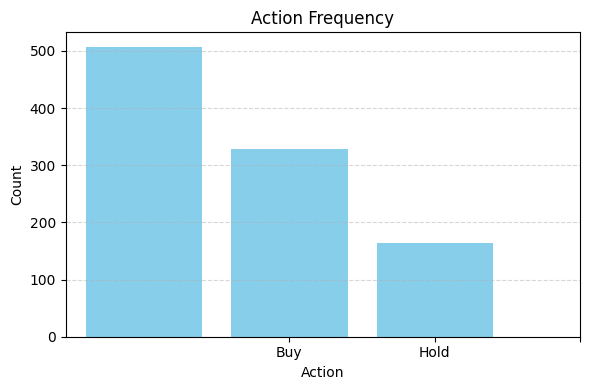

In [4]:
plt.figure(figsize=(6,4))
plt.bar(action_counts.index, action_counts.values, color='skyblue')
plt.xlabel('Action')
plt.ylabel('Count')
plt.title('Action Frequency')
plt.xticks([1, 2, 3])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

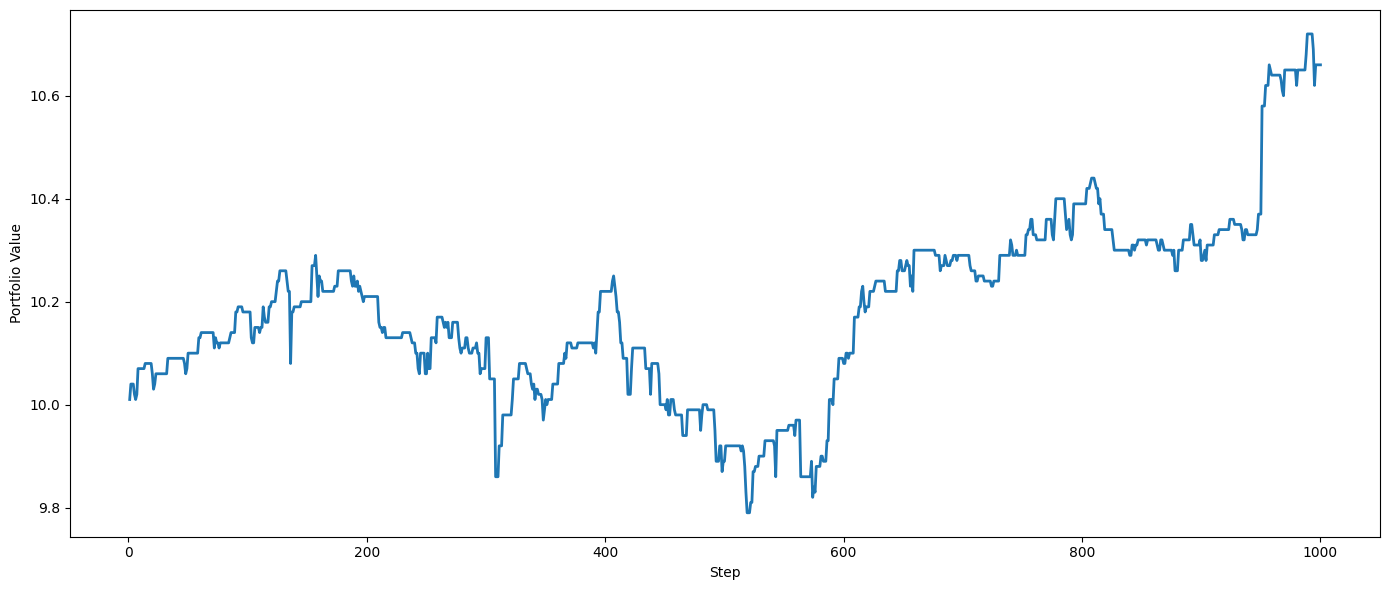

In [5]:
plt.figure(figsize=(14, 6))
plt.plot(df['step'], df['portfolio_value'], label="Portfolio Value", linewidth=2)
plt.xlabel("Step")
plt.ylabel("Portfolio Value")
plt.tight_layout()
plt.show()